In [1]:
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model
from PIL import Image

2025-07-24 16:42:49.594550: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753375369.786338      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753375369.840734      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
data_dir = '/kaggle/input/gtsrb-german-traffic-sign'
train_path = '/kaggle/input/gtsrb-german-traffic-sign/Train'
test_path = '/kaggle/input/gtsrb-german-traffic-sign/Test'

IMG_HEIGHT = 40
IMG_WIDTH = 40
IMG_HEIGHT_RESNET = 224
IMG_WIDTH_RESNET = 224
channels = 3
NUM_CATEGORIES = 43

In [3]:
# Load and preprocess training images
image_data = []
image_labels = []

for i in range(NUM_CATEGORIES):
    path = os.path.join(train_path, str(i))
    if not os.path.exists(path):
        print(f"Warning: Path {path} does not exist")
        continue
        
    images = os.listdir(path)
    for img in images:
        try:
            image = cv2.imread(os.path.join(path, img))
            if image is None:
                continue
            # Convert BGR to RGB
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = cv2.resize(image, (IMG_HEIGHT, IMG_WIDTH))
            image_data.append(image)
            image_labels.append(i)
        except Exception as e:
            print(f"Error processing {img}: {e}")

# Convert to numpy arrays
image_data = np.array(image_data, dtype=np.float32)
image_labels = np.array(image_labels)

print(f"Loaded {len(image_data)} training images")
print(f"Image shape: {image_data.shape}")
print(f"Labels shape: {image_labels.shape}")


Loaded 39209 training images
Image shape: (39209, 40, 40, 3)
Labels shape: (39209,)


In [4]:
test_csv = pd.read_csv('/kaggle/input/gtsrb-german-traffic-sign/Test.csv')

X_test = []
y_test = []

print("Loading test data...")
for _, row in test_csv.iterrows():
    img_path = os.path.join('/kaggle/input/gtsrb-german-traffic-sign', row['Path'])
    
    try:
        img = cv2.imread(img_path)
        if img is None:
            print(f"❌ Failed to load image: {img_path}")
            continue
        
        # Convert BGR to RGB (consistent with training)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (IMG_HEIGHT, IMG_WIDTH))
        X_test.append(img.astype(np.float32))
        y_test.append(row['ClassId'])
    except Exception as e:
        print(f"Error loading {img_path}: {e}")
        continue

X_test = np.array(X_test, dtype=np.float32)
y_test = np.array(y_test)

print(f"Loaded {len(X_test)} test images")

# Verify data consistency
print(f"Training data range: {image_data.min():.2f} to {image_data.max():.2f}")
print(f"Test data range: {X_test.min():.2f} to {X_test.max():.2f}")

Loading test data...
Loaded 12630 test images
Training data range: 0.00 to 255.00
Test data range: 0.00 to 255.00


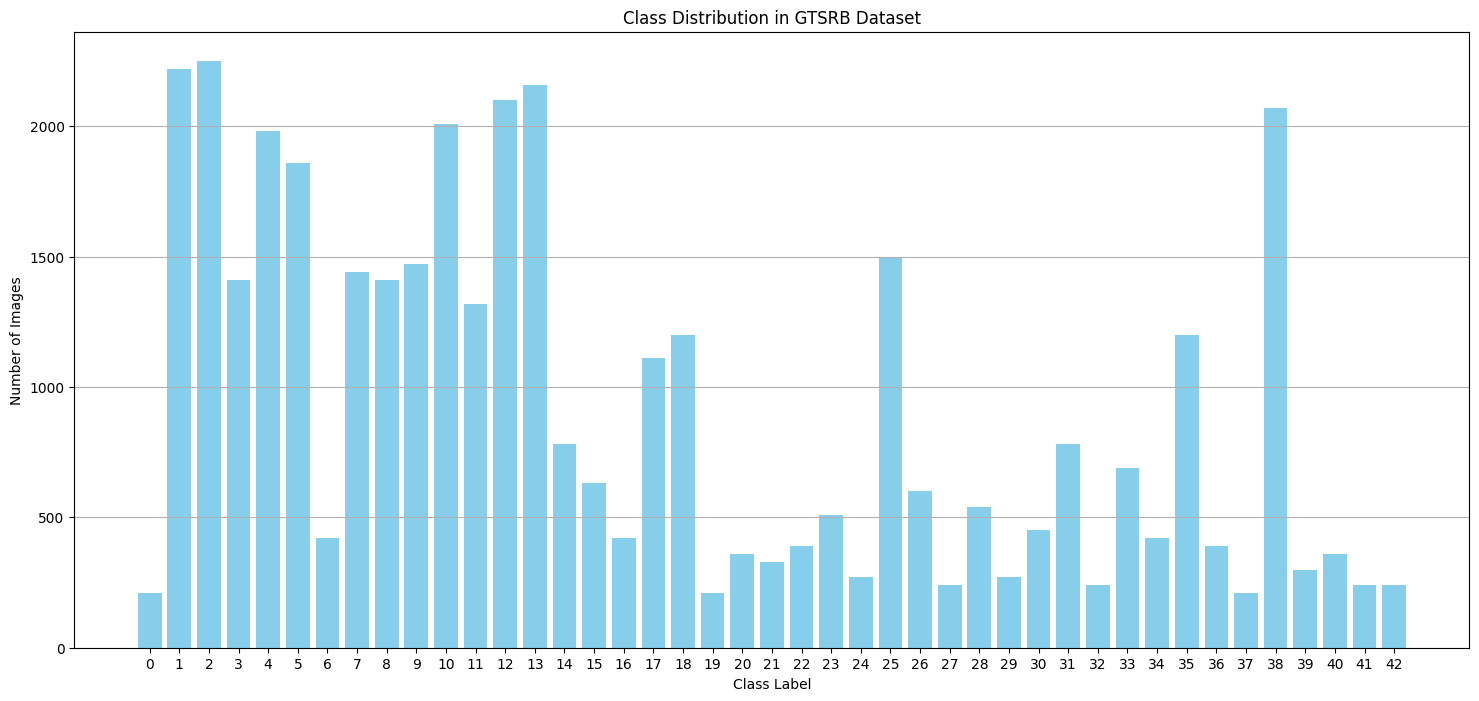

In [5]:
# Count number of samples per class
class_counts = np.bincount(image_labels)

# Plot class distribution
plt.figure(figsize=(18, 8))
plt.bar(range(NUM_CATEGORIES), class_counts, color='skyblue')
plt.xlabel("Class Label")
plt.ylabel("Number of Images")
plt.title("Class Distribution in GTSRB Dataset")
plt.xticks(range(NUM_CATEGORIES))
plt.grid(axis='y')
plt.show()

In [6]:
# Shuffle the dataset
shuffle_indexes = np.arange(image_data.shape[0])
np.random.shuffle(shuffle_indexes)
image_data = image_data[shuffle_indexes]
image_labels = image_labels[shuffle_indexes]

# Split training data into train and validation
X_train, X_val, y_train, y_val = train_test_split(image_data, image_labels, test_size=0.3, random_state=42, stratify=image_labels)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Validation set: {X_val.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")

# Normalize all data
X_train = X_train / 255.0
X_val = X_val / 255.0
X_test = X_test / 255.0

# One-hot encode labels
y_train_cat = to_categorical(y_train, NUM_CATEGORIES)
y_val_cat = to_categorical(y_val, NUM_CATEGORIES)
y_test_cat = to_categorical(y_test, NUM_CATEGORIES)

# Data augmentation
aug = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.15,
    fill_mode="nearest"
)

Training set: 27446 samples
Validation set: 11763 samples
Test set: 12630 samples


In [7]:
# Build CNN Model
cnn_model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, channels)),
    layers.BatchNormalization(),
    layers.MaxPooling2D(2, 2),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(2, 2),

    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(2, 2),

    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.4),
    layers.Dense(NUM_CATEGORIES, activation='softmax')
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1753375731.977618      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


In [8]:
cnn_model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [9]:
cnn_checkpoint = ModelCheckpoint("best_cnn_model.h5", monitor='val_accuracy', save_best_only=True, verbose=1)

# Train CNN
cnn_history = cnn_model.fit(
    aug.flow(X_train, y_train_cat, batch_size=64),
    validation_data=(X_val, y_val_cat),
    epochs=30,
    callbacks=[cnn_checkpoint]
)
cnn_model = load_model("best_cnn_model.h5")

Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1753375737.472980      59 service.cc:148] XLA service 0x7bdf080058d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1753375737.473800      59 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1753375737.986153      59 cuda_dnn.cc:529] Loaded cuDNN version 90300


  6/429 ━━━━━━━━━━━━━━━━━━━━ 13s 31ms/step - accuracy: 0.0448 - loss: 4.8303

I0000 00:00:1753375741.068319      59 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


428/429 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.4800 - loss: 2.0367
Epoch 1: val_accuracy improved from -inf to 0.80056, saving model to best_cnn_model.h5
429/429 ━━━━━━━━━━━━━━━━━━━━ 29s 50ms/step - accuracy: 0.4809 - loss: 2.0327 - val_accuracy: 0.8006 - val_loss: 0.6344
Epoch 2/30
428/429 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.9063 - loss: 0.3038
Epoch 2: val_accuracy improved from 0.80056 to 0.97849, saving model to best_cnn_model.h5
429/429 ━━━━━━━━━━━━━━━━━━━━ 17s 40ms/step - accuracy: 0.9064 - loss: 0.3036 - val_accuracy: 0.9785 - val_loss: 0.0800
Epoch 3/30
429/429 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.9535 - loss: 0.1473
Epoch 3: val_accuracy improved from 0.97849 to 0.99141, saving model to best_cnn_model.h5
429/429 ━━━━━━━━━━━━━━━━━━━━ 17s 39ms/step - accuracy: 0.9535 - loss: 0.1473 - val_accuracy: 0.9914 - val_loss: 0.0305
Epoch 4/30
429/429 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.9714 - loss: 0.0935
Epoch 4: val_accuracy did not improve f

In [10]:
# Evaluate CNN on test set
cnn_test_preds = cnn_model.predict(X_test)
cnn_test_pred_classes = np.argmax(cnn_test_preds, axis=1)
print("CNN Test Set Classification Report:")
print(classification_report(y_test, cnn_test_pred_classes))

395/395 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
CNN Test Set Classification Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99        60
           1       0.97      0.99      0.98       720
           2       0.99      0.99      0.99       750
           3       0.97      0.98      0.98       450
           4       1.00      0.98      0.99       660
           5       0.95      0.99      0.97       630
           6       1.00      0.96      0.98       150
           7       1.00      0.99      0.99       450
           8       0.97      0.97      0.97       450
           9       0.99      1.00      1.00       480
          10       0.99      0.99      0.99       660
          11       1.00      0.97      0.99       420
          12       0.98      0.99      0.99       690
          13       0.98      1.00      0.99       720
          14       1.00      1.00      1.00       270
          15       0.98      1.00      0.99       210
    

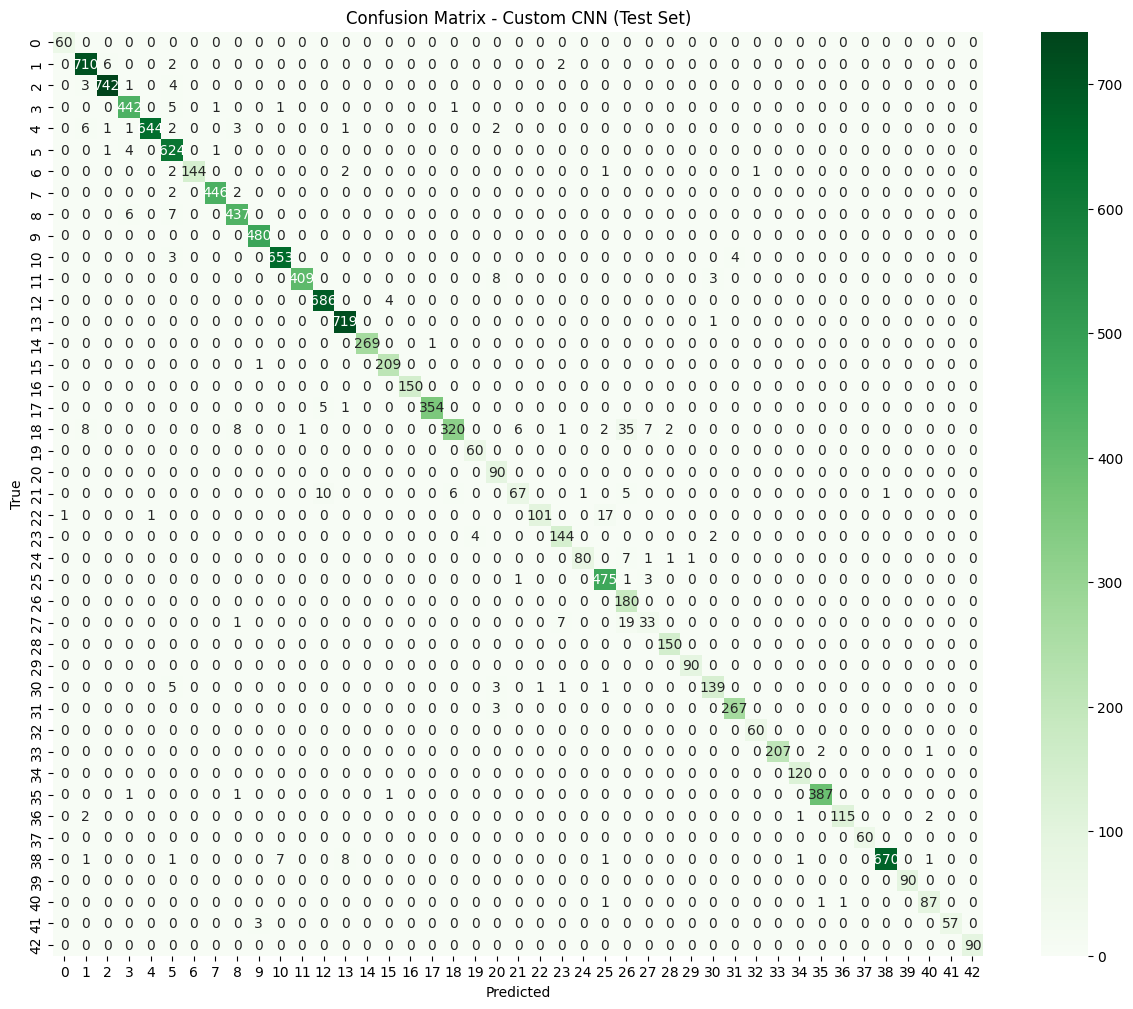

In [11]:
# CNN Confusion Matrix
plt.figure(figsize=(15, 12))
sns.heatmap(confusion_matrix(y_test, cnn_test_pred_classes), cmap='Greens', annot=True, fmt='d')
plt.title("Confusion Matrix - Custom CNN (Test Set)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

In [12]:
# Prepare data for ResNet50 - resize to 224x224
IMG_SIZE = (224, 224)

def preprocess_resnet(image, label):
    image = tf.image.resize(image, IMG_SIZE)
    image = preprocess_input(image * 255.0)
    return image, label

# Convert your data
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train_cat))
val_ds   = tf.data.Dataset.from_tensor_slices((X_val, y_val_cat))
test_ds  = tf.data.Dataset.from_tensor_slices((X_test, y_test_cat))

# Apply preprocessing and batching
train_ds = train_ds.map(preprocess_resnet, num_parallel_calls=tf.data.AUTOTUNE).batch(32).prefetch(tf.data.AUTOTUNE)
val_ds   = val_ds.map(preprocess_resnet, num_parallel_calls=tf.data.AUTOTUNE).batch(32).prefetch(tf.data.AUTOTUNE)
test_ds  = test_ds.map(preprocess_resnet, num_parallel_calls=tf.data.AUTOTUNE).batch(32).prefetch(tf.data.AUTOTUNE)

In [13]:
# Load ResNet50 base model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT_RESNET, IMG_WIDTH_RESNET, 3))

# Build custom head for ResNet50
x = base_model.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.5)(x)
output = layers.Dense(NUM_CATEGORIES, activation='softmax')(x)

resnet_model = models.Model(inputs=base_model.input, outputs=output)

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [14]:
# Compile
resnet_model.compile(optimizer=Adam(learning_rate=0.0005), loss='categorical_crossentropy', metrics=['accuracy'])

In [15]:
resnet_checkpoint = ModelCheckpoint("best_resnet_model.h5", monitor='val_accuracy', save_best_only=True, verbose=1)

# Train ResNet50
resnet_history = resnet_model.fit(train_ds, validation_data=val_ds, epochs=20, callbacks=[resnet_checkpoint])

resnet_model = load_model("best_resnet_model.h5")

Epoch 1/20
858/858 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step - accuracy: 0.7792 - loss: 0.8771
Epoch 1: val_accuracy improved from -inf to 0.98861, saving model to best_resnet_model.h5
858/858 ━━━━━━━━━━━━━━━━━━━━ 256s 214ms/step - accuracy: 0.7793 - loss: 0.8765 - val_accuracy: 0.9886 - val_loss: 0.0518
Epoch 2/20
858/858 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - accuracy: 0.9833 - loss: 0.0726
Epoch 2: val_accuracy improved from 0.98861 to 0.99515, saving model to best_resnet_model.h5
858/858 ━━━━━━━━━━━━━━━━━━━━ 155s 181ms/step - accuracy: 0.9833 - loss: 0.0726 - val_accuracy: 0.9952 - val_loss: 0.0176
Epoch 3/20
858/858 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - accuracy: 0.9874 - loss: 0.0552
Epoch 3: val_accuracy did not improve from 0.99515
858/858 ━━━━━━━━━━━━━━━━━━━━ 153s 179ms/step - accuracy: 0.9874 - loss: 0.0552 - val_accuracy: 0.9659 - val_loss: 0.1351
Epoch 4/20
858/858 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - accuracy: 0.9924 - loss: 0.0337
Epoch 4: val_accuracy did not improve from 0.99515


In [16]:
# Evaluate ResNet50 on test set
resnet_test_preds = resnet_model.predict(test_ds)
resnet_test_pred_classes = np.argmax(resnet_test_preds, axis=1)

print("ResNet50 Test Set Classification Report:")
print(classification_report(y_test, resnet_test_pred_classes))

395/395 ━━━━━━━━━━━━━━━━━━━━ 26s 55ms/step
ResNet50 Test Set Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        60
           1       0.99      1.00      1.00       720
           2       0.99      1.00      0.99       750
           3       0.99      0.98      0.99       450
           4       1.00      0.99      0.99       660
           5       0.95      0.99      0.97       630
           6       1.00      0.83      0.91       150
           7       0.97      1.00      0.99       450
           8       0.99      0.94      0.96       450
           9       1.00      1.00      1.00       480
          10       1.00      1.00      1.00       660
          11       1.00      0.99      0.99       420
          12       1.00      0.99      0.99       690
          13       0.99      1.00      1.00       720
          14       1.00      1.00      1.00       270
          15       0.99      1.00      0.99       2

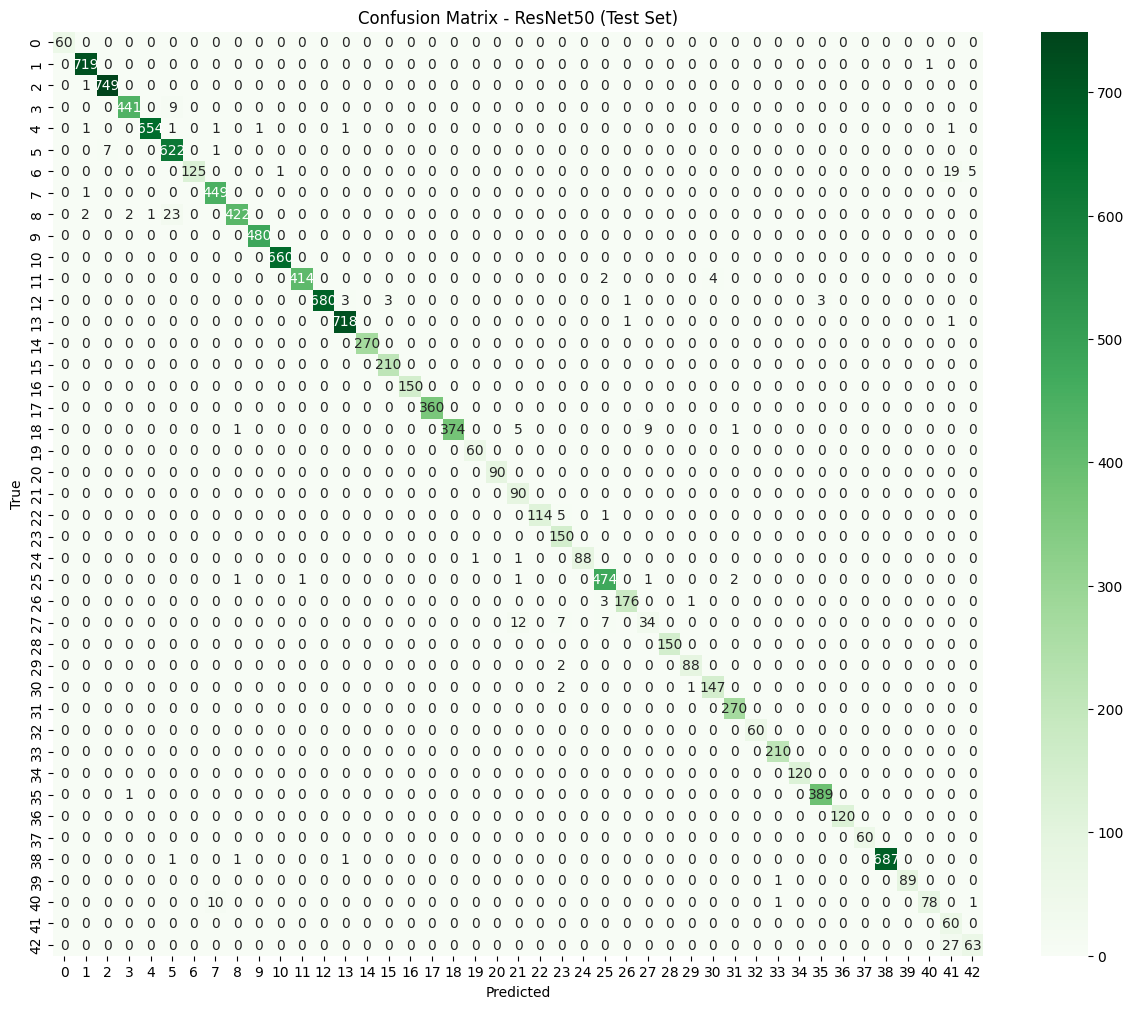

In [17]:
# ResNet Confusion Matrix
plt.figure(figsize=(15, 12))
sns.heatmap(confusion_matrix(y_test, resnet_test_pred_classes), cmap='Greens', annot=True, fmt='d')
plt.title("Confusion Matrix - ResNet50 (Test Set)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

In [18]:
# Compare model performance
print("\n=== Model Performance Comparison ===")
print(f"CNN Test Accuracy: {np.mean(cnn_test_pred_classes == y_test):.4f}")
print(f"ResNet50 Test Accuracy: {np.mean(resnet_test_pred_classes == y_test):.4f}")


=== Model Performance Comparison ===
CNN Test Accuracy: 0.9752
ResNet50 Test Accuracy: 0.9837


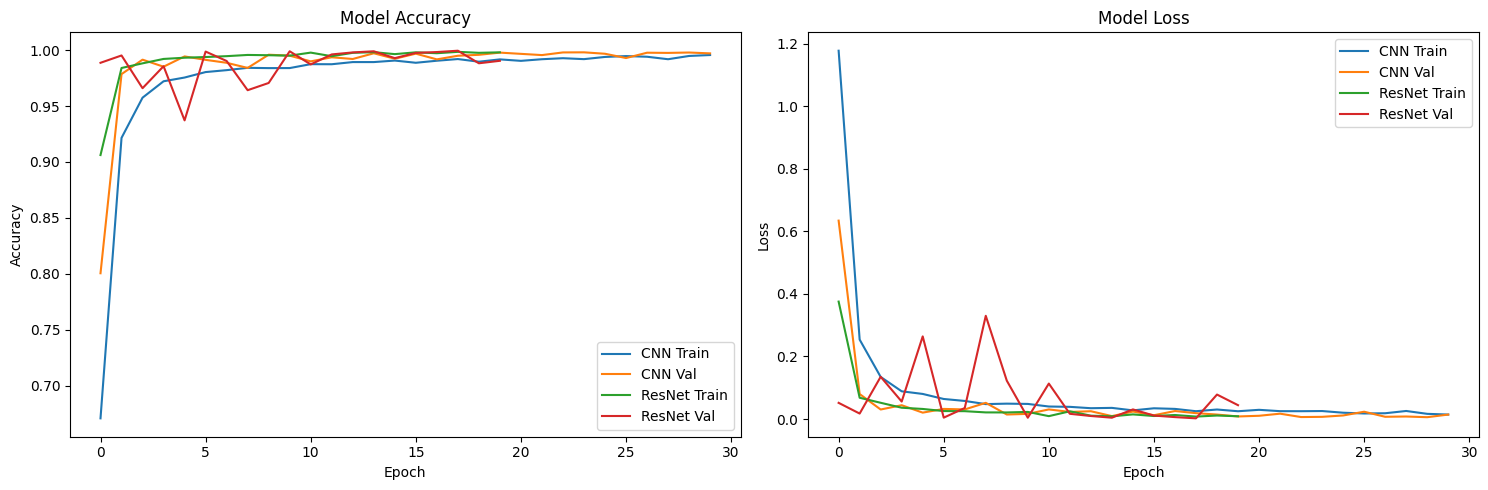

In [19]:
# Plot training history
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(cnn_history.history['accuracy'], label='CNN Train')
plt.plot(cnn_history.history['val_accuracy'], label='CNN Val')
plt.plot(resnet_history.history['accuracy'], label='ResNet Train')
plt.plot(resnet_history.history['val_accuracy'], label='ResNet Val')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(cnn_history.history['loss'], label='CNN Train')
plt.plot(cnn_history.history['val_loss'], label='CNN Val')
plt.plot(resnet_history.history['loss'], label='ResNet Train')
plt.plot(resnet_history.history['val_loss'], label='ResNet Val')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()